In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import xgcm

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 12

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(30)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: scheduler='tcp://10.148.0.254:34152' processes=60 cores=240>

_________
# Read dataset


In [65]:
Nf = 720

data_dir = '/home1/scratch/xyu/mit_nc_t/'

filenames_Eta = sorted(glob(data_dir+'Eta_*.nc'))
filenames_Eta = filenames_Eta[:Nf]
%time ds_Eta = xr.open_mfdataset(filenames_Eta, concat_dim='time', compat='equals', decode_cf=False)

filenames_SSU = sorted(glob(data_dir+'SSU_*.nc'))
filenames_SSU = filenames_SSU[:Nf]
%time ds_SSU = xr.open_mfdataset(filenames_SSU, concat_dim='time', compat='equals', decode_cf=False)

filenames_SSV = sorted(glob(data_dir+'SSV_*.nc'))
filenames_SSV = filenames_SSV[:Nf]
%time ds_SSV = xr.open_mfdataset(filenames_SSV, concat_dim='time', compat='equals', decode_cf=False)

%time grid = xr.open_dataset('/home1/scratch/xyu/mit_grid.nc', decode_coords=False)

CPU times: user 4.33 s, sys: 1.5 s, total: 5.83 s
Wall time: 5.89 s
CPU times: user 4.82 s, sys: 1.57 s, total: 6.38 s
Wall time: 6.47 s
CPU times: user 4.3 s, sys: 1.51 s, total: 5.82 s
Wall time: 5.88 s
CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 27.9 ms


In [66]:
%time ds = xr.merge([ds_Eta, ds_SSU, ds_SSV, grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['Eta'].nbytes / 1e9))

CPU times: user 20.8 s, sys: 1.2 s, total: 22 s
Wall time: 30.5 s
<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 720)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    dtime    (time) int64 dask.array<shape=(720,), chunksize=(1,)>
    Eta      (time, face, j, i) float32 dask.array<shape=(720, 13, 4320, 4320), chunksize=(1, 13, 4320, 4320)>
    SSU      (time, face, j, i_g) float32 dask.array<shape=(720, 13, 4320, 4320), chunksize=(1, 13, 4320, 4320)>
    SSV      (time, face, j_g, i) float32 dask.array<shape=(720, 13,

In [68]:
E_dir = '/home1/scratch/xyu/momentum/'
face_1 = 1 # some key faces

---


# 1. Time derivative of SSU ($G_u$)

A central difference is applied to compute du/dt.

In [69]:
d_SSU_dt_time = ( ds['SSU'].shift(time=-1) - ds['SSU'].shift(time=1) )/2/3600
d_SSU_dt_time = d_SSU_dt_time.rename('d_SSU_dt_time').sel(face=face_1)
print(d_SSU_dt_time)

<xarray.DataArray 'd_SSU_dt_time' (time: 720, j: 4320, i_g: 4320)>
dask.array<shape=(720, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320)>
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...


In [71]:
d_SSU_dt_time.to_dataset().to_zarr(E_dir+'d_SSU_dt_time_f%02d.nc'% (face_1), mode='w')

In [72]:
ds_tmp = xr.open_zarr(E_dir+'d_SSU_dt_time_f%02d.nc'% (face_1))
print(ds_tmp)

<xarray.Dataset>
Dimensions:        (i_g: 4320, j: 4320, time: 720)
Coordinates:
    face           int64 ...
  * i_g            (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j              (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * time           (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
Data variables:
    d_SSU_dt_time  (time, j, i_g) float32 dask.array<shape=(720, 4320, 4320), chunksize=(1, 4320, 4320)>


In [8]:
T = np.arange(0, Nf-1)

In [ ]:
for t in T:
        
    d_SSU_dt_time = (ds['SSU'].isel(face=face_1,time=t+2) - ds['SSU'].isel(face=face_1,time=t))/2/3600    
    d_SSU_dt_time = np.real(d_SSU_dt_time).rename('d_SSU_dt_time')
    file_E = E_dir+'d_SSU_dt_time_f%02d_t%04d.nc'% (face_1,t+1)                                                                                                      
    d_SSU_dt_time.to_netcdf(file_E, mode='w')  
    print('time %d done'%t )

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 0 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 1 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 2 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 3 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 4 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 5 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 6 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 7 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 8 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 9 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


_______

# 2. Coriolis terms ($G_u^{fv}$)

Next we create a `Grid` object from the dataset.
We need to tell xgcm that the `X` and `Y` axes are periodic.
(The other axes will be assumed to be non-periodic.)

In [19]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   j (4320) --> left
  * left     j_g (4320) --> center
X Axis (periodic):
  * center   i (4320) --> left
  * left     i_g (4320) --> center

In [20]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_j = grid.interp(f,'Y').load()

In [21]:
dxgSSV_j = grid.interp(ds.dxG.isel(face=face_1) * ds['SSV'].isel(face=face_1),'Y') 
dxgSSV_ji = grid.interp(dxgSSV_j,'X')    # SSV at (i_g,j)
zeta_3 = (grid.diff(ds.dyC.isel(face=face_1) * ds['SSV'].isel(face=face_1),'X') - grid.diff(ds.dxC.isel(face=face_1) * ds['SSU'].isel(face=face_1),'Y'))/ds.rAz.isel(face=face_1) # relative vorticity  
Coriolis_u = (f_j.isel(face=face_1) + grid.interp(zeta_3,'Y')) * dxgSSV_ji /ds.dxC.isel(face=face_1)    #(f+zeta)*SSV
Coriolis_u = np.real(Coriolis_u).rename('Coriolis_u')
print(Coriolis_u)

<xarray.DataArray 'Coriolis_u' (j: 4320, i_g: 4320, time: 720)>
dask.array<shape=(4320, 4320, 720), dtype=float32, chunksize=(1, 1, 1)>
Coordinates:
    face     int64 1
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...


In [22]:
Coriolis_u = Coriolis_u.chunk({'time': 1,'i_g':4320,'j':4320})
print(Coriolis_u)

<xarray.DataArray 'Coriolis_u' (j: 4320, i_g: 4320, time: 720)>
dask.array<shape=(4320, 4320, 720), dtype=float32, chunksize=(4320, 4320, 1)>
Coordinates:
    face     int64 1
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...


In [23]:
Coriolis_u.to_dataset().to_zarr(E_dir+'Coriolis_u_f%02d.nc'% (face_1), mode='w')

In [24]:
ds_Coriolis = xr.open_zarr(E_dir+'Coriolis_u_f%02d.nc'% (face_1))
print(ds_Coriolis)

<xarray.Dataset>
Dimensions:     (i_g: 4320, j: 4320, time: 720)
Coordinates:
    face        int64 ...
  * i_g         (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * j           (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time        (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
Data variables:
    Coriolis_u  (j, i_g, time) float32 dask.array<shape=(4320, 4320, 720), chunksize=(4320, 4320, 1)>


In [ ]:
for t in T:

    dxgSSV_j = grid.interp(ds.dxG.isel(face=face_1) * ds['SSV'].isel(face=face_1,time=t),'Y') 
    dxgSSV_ji = grid.interp(dxgSSV_j,'X')    # SSV at (i_g,j)
    zeta_3 = (grid.diff(ds.dyC.isel(face=face_1) * ds['SSV'].isel(face=face_1,time=t),'X') - grid.diff(ds.dxC.isel(face=face_1) * ds['SSU'].isel(face=face_1,time=t),'Y'))/ds.rAz.isel(face=face_1) # relative vorticity  
    Coriolis_u = (f_j.isel(face=face_1) + grid.interp(zeta_3,'Y')) * dxgSSV_ji /ds.dxC.isel(face=face_1)    #(f+zeta)*SSV
    Coriolis_u = np.real(Coriolis_u).rename('Coriolis_u')
    file_E = E_dir+'Coriolis_u_f%02d_t%04d.nc'% (face_1,t)                                                                                                          
    Coriolis_u.to_netcdf(file_E, mode='w')  
    print('time %d done'%t )


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 374.11 MB detected in task graph: 
  ("('__array_wrap__-7b9cd6d5e86bc6e1434da9ac433acf2 ... 4470>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


time 0 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 1 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 2 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 3 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 4 done


# 3. Gradient of Bernoulli function

In [ ]:
face_connections = {'face': {0: {'X': ((12, 'Y', False), (3, 'X', False)),
                                 'Y': (None, (1, 'Y', False))},
                             1: {'X': ((11, 'Y', False), (4, 'X', False)),
                                 'Y': ((0, 'Y', False), (2, 'Y', False))},
                             2: {'X': ((10, 'Y', False), (5, 'X', False)),
                                 'Y': ((1, 'Y', False), (6, 'X', False))},
                             3: {'X': ((0, 'X', False), (9, 'Y', False)),
                                 'Y': (None, (4, 'Y', False))},
                             4: {'X': ((1, 'X', False), (8, 'Y', False)),
                                 'Y': ((3, 'Y', False), (5, 'Y', False))},
                             5: {'X': ((2, 'X', False), (7, 'Y', False)),
                                 'Y': ((4, 'Y', False), (6, 'Y', False))},
                             6: {'X': ((2, 'Y', False), (7, 'X', False)),
                                 'Y': ((5, 'Y', False), (10, 'X', False))},
                             7: {'X': ((6, 'X', False), (8, 'X', False)),
                                 'Y': ((5, 'X', False), (10, 'Y', False))},
                             8: {'X': ((7, 'X', False), (9, 'X', False)),
                                 'Y': ((4, 'X', False), (11, 'Y', False))},
                             9: {'X': ((8, 'X', False), None),
                                 'Y': ((3, 'X', False), (12, 'Y', False))},
                             10: {'X': ((6, 'Y', False), (11, 'X', False)),
                                  'Y': ((7, 'Y', False), (2, 'X', False))},
                             11: {'X': ((10, 'X', False), (12, 'X', False)),
                                  'Y': ((8, 'Y', False), (1, 'X', False))},
                             12: {'X': ((11, 'X', False), None),
                                  'Y': ((9, 'Y', False), (0, 'X', False))}}}
x_grid = xgcm.Grid(ds, face_connections=face_connections)
print(x_grid)

for t in T:

    KE = (grid.interp(ds['SSU']**2,'X') + grid.interp(ds['SSV']**2,'Y'))/2
    Bx = (x_grid.diff(g*ds['Eta'].isel(time=t),'X') + x_grid.diff(KE.isel(time=t),'X'))/ds.dxC
    dB_dx = Bx.isel(face=face_1)
    dB_dx = np.real(dB_dx).rename('dB_dx')    
    file_E = E_dir+'dB_dx_f%02d_t%04d.nc'% (face_1,t)      
    dB_dx.to_netcdf(file_E, mode='w')  
    print('time %d done'%t )

In [41]:
g = 9.81
T = np.arange(0, 720)

In [ ]:
for t in T:

    KE = (grid.interp(ds['SSU'].isel(face=face_1,time=t)**2,'X') + grid.interp(ds['SSV'].isel(face=face_1,time=t)**2,'Y'))/2 # KE
    dB_dx = (grid.diff(g*ds['Eta'].isel(face=face_1,time=t),'X') + grid.diff(KE,'X'))/ds.dxC.isel(face=face_1)     # d(Eta*g + KE)/dx
    dB_dx = np.real(dB_dx).rename('dB_dx')    
    file_E = E_dir+'dB_dx_f%02d_t%04d.nc'% (face_1,t)      
    dB_dx.to_netcdf(file_E, mode='w')  
    print('time %d done'%t )

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 269 done
time 270 done
time 271 done
time 272 done
time 273 done
time 274 done
time 275 done
time 276 done
time 277 done
time 278 done
time 279 done
time 280 done
time 281 done


In [26]:
g = 9.81
KE = (grid.interp(ds['SSU'].isel(face=face_1)**2,'X') + grid.interp(ds['SSV'].isel(face=face_1)**2,'Y'))/2 # KE
dB_dx = (grid.diff(g*ds['Eta'].isel(face=face_1),'X') + grid.diff(KE,'X'))/ds.dxC.isel(face=face_1)     # d(Eta*g + KE)/dx
dB_dx = np.real(dB_dx).rename('dB_dx')    
print(dB_dx)

<xarray.DataArray 'dB_dx' (time: 720, j: 4320, i_g: 4320)>
dask.array<shape=(720, 4320, 4320), dtype=float32, chunksize=(1, 4319, 1)>
Coordinates:
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face     int64 1


In [27]:
dB_dx = dB_dx.chunk({'time': 1,'i_g':4320,'j':4320})
print(dB_dx)

<xarray.DataArray 'dB_dx' (time: 720, j: 4320, i_g: 4320)>
dask.array<shape=(720, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320)>
Coordinates:
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face     int64 1


In [28]:
dB_dx.to_dataset().to_zarr(E_dir+'dB_dx_f%02d.nc'% (face_1), mode='w')

In [29]:
ds_B = xr.open_zarr(E_dir+'dB_dx_f%02d.nc'% (face_1))
print(ds_B)

<xarray.Dataset>
Dimensions:  (i_g: 4320, j: 4320, time: 720)
Coordinates:
    face     int64 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
Data variables:
    dB_dx    (time, j, i_g) float32 dask.array<shape=(720, 4320, 4320), chunksize=(1, 4320, 4320)>


# 4. Residuals_new

In [73]:
ds_tmp = xr.open_zarr(E_dir+'d_SSU_dt_time_f%02d.nc'% (face_1))
print(ds_tmp)

<xarray.Dataset>
Dimensions:        (i_g: 4320, j: 4320, time: 720)
Coordinates:
    face           int64 ...
  * i_g            (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j              (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * time           (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
Data variables:
    d_SSU_dt_time  (time, j, i_g) float32 dask.array<shape=(720, 4320, 4320), chunksize=(1, 4320, 4320)>


In [31]:
ds_Coriolis = xr.open_zarr(E_dir+'Coriolis_u_f%02d.nc'% (face_1))
print(ds_Coriolis)

<xarray.Dataset>
Dimensions:     (i_g: 4320, j: 4320, time: 720)
Coordinates:
    face        int64 ...
  * i_g         (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * j           (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time        (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
Data variables:
    Coriolis_u  (j, i_g, time) float32 dask.array<shape=(4320, 4320, 720), chunksize=(4320, 4320, 1)>


In [32]:
ds_B = xr.open_zarr(E_dir+'dB_dx_f%02d.nc'% (face_1))
print(ds_B)

<xarray.Dataset>
Dimensions:  (i_g: 4320, j: 4320, time: 720)
Coordinates:
    face     int64 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
Data variables:
    dB_dx    (time, j, i_g) float32 dask.array<shape=(720, 4320, 4320), chunksize=(1, 4320, 4320)>


In [74]:
%time ds = xr.merge([ds_tmp,ds_Coriolis,ds_B])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 13 ms
<xarray.Dataset>
Dimensions:        (i_g: 4320, j: 4320, time: 720)
Coordinates:
    face           int64 1
  * i_g            (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j              (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * time           (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
Data variables:
    d_SSU_dt_time  (time, j, i_g) float32 dask.array<shape=(720, 4320, 4320), chunksize=(1, 4320, 4320)>
    Coriolis_u     (j, i_g, time) float32 dask.array<shape=(4320, 4320, 720), chunksize=(4320, 4320, 1)>
    dB_dx          (time, j, i_g) float32 dask.array<shape=(720, 4320, 4320), chunksize=(1, 4320, 4320)>

 data size: 161.2 GB


In [75]:
residuals_u_face1 = (ds['d_SSU_dt_time'] - ds['Coriolis_u'] + ds['dB_dx'])
print(residuals_u_face1)

<xarray.DataArray (time: 720, j: 4320, i_g: 4320)>
dask.array<shape=(720, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320)>
Coordinates:
    face     int64 1
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...


In [76]:
residuals_u_face1 = np.real(residuals_u_face1).rename('residuals_u_face1')    
residuals_u_face1.to_dataset().to_zarr(E_dir+'residuals_u_face1_f%02d.nc'% (face_1), mode='w')

In [77]:
ds_residuals = xr.open_zarr(E_dir+'residuals_u_face1_f%02d.nc'% (face_1))
print(ds_residuals)

<xarray.Dataset>
Dimensions:            (i_g: 4320, j: 4320, time: 720)
Coordinates:
    face               int64 ...
  * i_g                (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * time               (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
Data variables:
    residuals_u_face1  (time, j, i_g) float32 dask.array<shape=(720, 4320, 4320), chunksize=(1, 4320, 4320)>


In [78]:
%time ds = xr.merge([ds,ds_residuals])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.23 ms
<xarray.Dataset>
Dimensions:            (i_g: 4320, j: 4320, time: 720)
Coordinates:
    face               int64 1
  * i_g                (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * time               (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
Data variables:
    d_SSU_dt_time      (time, j, i_g) float32 dask.array<shape=(720, 4320, 4320), chunksize=(1, 4320, 4320)>
    Coriolis_u         (j, i_g, time) float32 dask.array<shape=(4320, 4320, 720), chunksize=(4320, 4320, 1)>
    dB_dx              (time, j, i_g) float32 dask.array<shape=(720, 4320, 4320), chunksize=(1, 4320, 4320)>
    residuals_u_face1  (time, j, i_g) float32 dask.array<shape=(720, 4320, 4320), chunksize=(1, 4320, 4320)>

 data size: 215.0 GB


In [79]:
# std
residuals_u_face1_std = ds['residuals_u_face1'].isel(i_g=slice(500,1500),j=slice(500,2000)).std(['i_g','j']).load()
Coriolis_u_std = ds['Coriolis_u'].isel(i_g=slice(500,1500),j=slice(500,2000)).std(['i_g','j']).load()
dB_dx_std = ds['dB_dx'].isel(i_g=slice(500,1500),j=slice(500,2000)).std(['i_g','j']).load()
d_SSU_dt_time_std = ds['d_SSU_dt_time'].isel(i_g=slice(500,1500),j=slice(500,2000)).std(['i_g','j']).load()

(0, 2.5e-05)

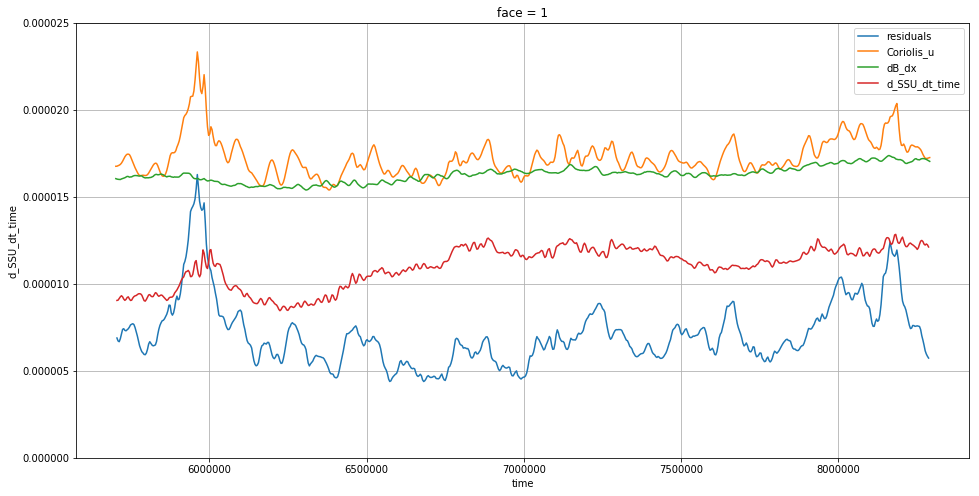

In [81]:
# std
fig, ax = plt.subplots(figsize=(16,8))
labels = ['residuals', 'Coriolis_u','dB_dx','d_SSU_dt_time']

residuals_u_face1_std.plot(ax=ax, label=labels[0])
Coriolis_u_std.plot(ax=ax, label=labels[1])
dB_dx_std.plot(ax=ax, label=labels[2])
d_SSU_dt_time_std.plot(ax=ax, label=labels[3])
ax.legend(); ax.grid()
#ax.set_xlim([0,480])
ax.set_ylim([0,2.5*1e-5])

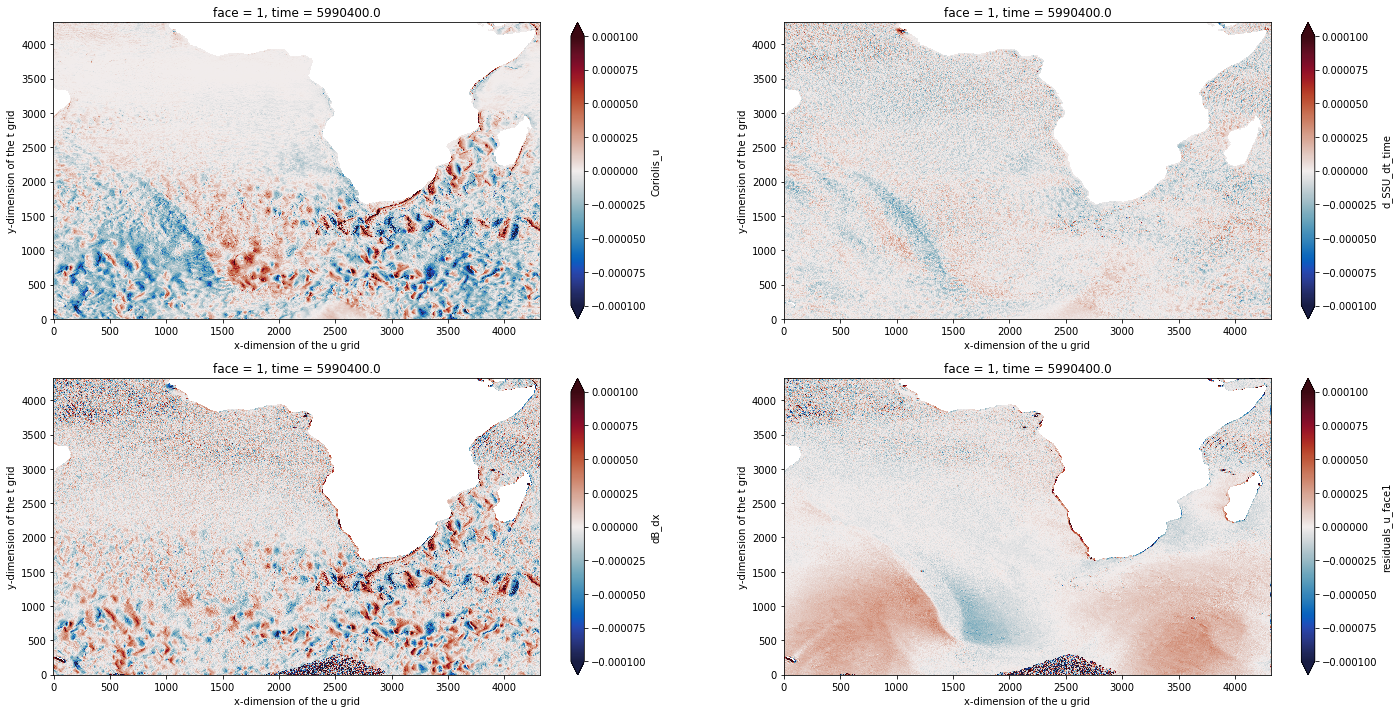

In [82]:
fig = plt.figure(figsize = (24,12))

plt.subplot(221)
ds['Coriolis_u'].isel(time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(222)
ds['d_SSU_dt_time'].isel(time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(223)
ds['dB_dx'].isel(time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(224)
ds['residuals_u_face1'].isel(time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

# 4. Residuals

In [14]:
N_open = 480
#N_open = 120

E_dir = '/home1/scratch/xyu/mit_nc/'

In [15]:
filenames_1 = sorted(glob(E_dir+'Coriolis_u_f01_t*.nc'))
filenames_1 = filenames_1[1:N_open]
%time ds_1 = xr.open_mfdataset(filenames_1, concat_dim='time', compat='equals', decode_cf=False)

filenames_2 = sorted(glob(E_dir+'d_SSU_dt_time_f01_t*.nc'))
filenames_2 = filenames_2[1:N_open]
%time ds_2 = xr.open_mfdataset(filenames_2, concat_dim='time', compat='equals', decode_cf=False)

filenames_3 = sorted(glob(E_dir+'dB_dx_f01_t*.nc'))
filenames_3 = filenames_3[1:N_open]
%time ds_3 = xr.open_mfdataset(filenames_3, concat_dim='time', compat='equals', decode_cf=False)

CPU times: user 5.69 s, sys: 2.37 s, total: 8.06 s
Wall time: 1min 19s
CPU times: user 5.44 s, sys: 2.16 s, total: 7.6 s
Wall time: 1min 12s
CPU times: user 5.74 s, sys: 2.22 s, total: 7.96 s
Wall time: 1min 27s


In [17]:
%time ds = xr.merge([ds_1,ds_2,ds_3])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 2min 19s, sys: 8.31 s, total: 2min 27s
Wall time: 4min 43s
<xarray.Dataset>
Dimensions:        (i_g: 4320, j: 4320, time: 479)
Coordinates:
  * j              (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * i_g            (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Dimensions without coordinates: time
Data variables:
    face           (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    dyG            (time, j, i_g) float32 dask.array<shape=(479, 4320, 4320), chunksize=(1, 4320, 4320)>
    dxC            (time, j, i_g) float32 dask.array<shape=(479, 4320, 4320), chunksize=(1, 4320, 4320)>
    rAw            (time, j, i_g) float32 dask.array<shape=(479, 4320, 4320), chunksize=(1, 4320, 4320)>
    Coriolis_u     (time, j, i_g) float32 dask.array<shape=(479, 4320, 4320), chunksize=(1, 4320, 4320)>
    d_SSU_dt_time  (time, j, i_g) float32 dask.array<shape=(479, 4320, 4320), chunksize=(1, 4320, 4320)>
    dB_dx          (time, j

In [16]:
%time residuals_u_face1 = (ds['d_SSU_dt_time'] - ds['Coriolis_u'] + ds['dB_dx']).load()
print(residuals_u_face1)

CPU times: user 1min 29s, sys: 2min 5s, total: 3min 35s
Wall time: 3min 2s
<xarray.DataArray (time: 479, j: 4320, i_g: 4320)>
array([[[-4.474729e-05, -4.468339e-06, ..., -5.822873e-06, -5.780633e-06],
        [-2.582579e-05, -1.524413e-07, ..., -9.770432e-06, -9.242965e-06],
        ...,
        [ 6.067454e-06,  4.178451e-06, ...,  2.897446e-06,  5.194416e-06],
        [-2.460253e-05, -1.319541e-05, ..., -3.855219e-06, -8.859575e-06]],

       [[-3.028262e-05,  1.597712e-06, ..., -3.093354e-06,  3.373754e-06],
        [-1.808310e-05,  4.017196e-06, ..., -1.798203e-06,  4.609339e-06],
        ...,
        [-2.739991e-06, -1.056930e-05, ...,  1.614298e-06,  2.599428e-06],
        [-1.163991e-05, -7.477613e-06, ..., -2.128599e-06, -7.070470e-06]],

       ...,

       [[-3.909222e-03,  2.536678e-05, ...,  3.152397e-05,  2.953633e-05],
        [-3.907463e-03,  5.749578e-06, ...,  1.632635e-05,  1.567413e-05],
        ...,
        [-5.649867e-03, -3.200658e-05, ..., -7.026973e-06, -8.753446

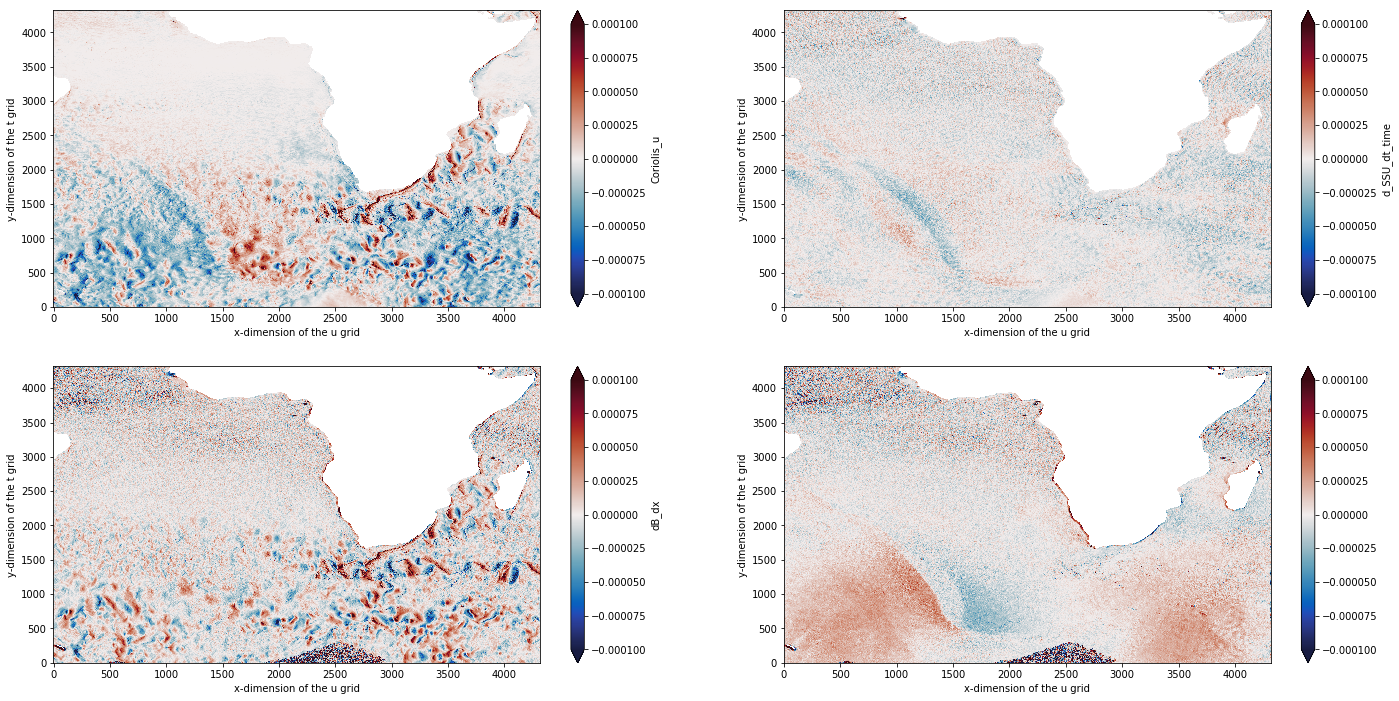

In [36]:
fig = plt.figure(figsize = (24,12))

plt.subplot(221)
ds['Coriolis_u'].isel(time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(222)
ds['d_SSU_dt_time'].isel(time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(223)
ds['dB_dx'].isel(time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(224)
residuals_u_face1.isel(time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

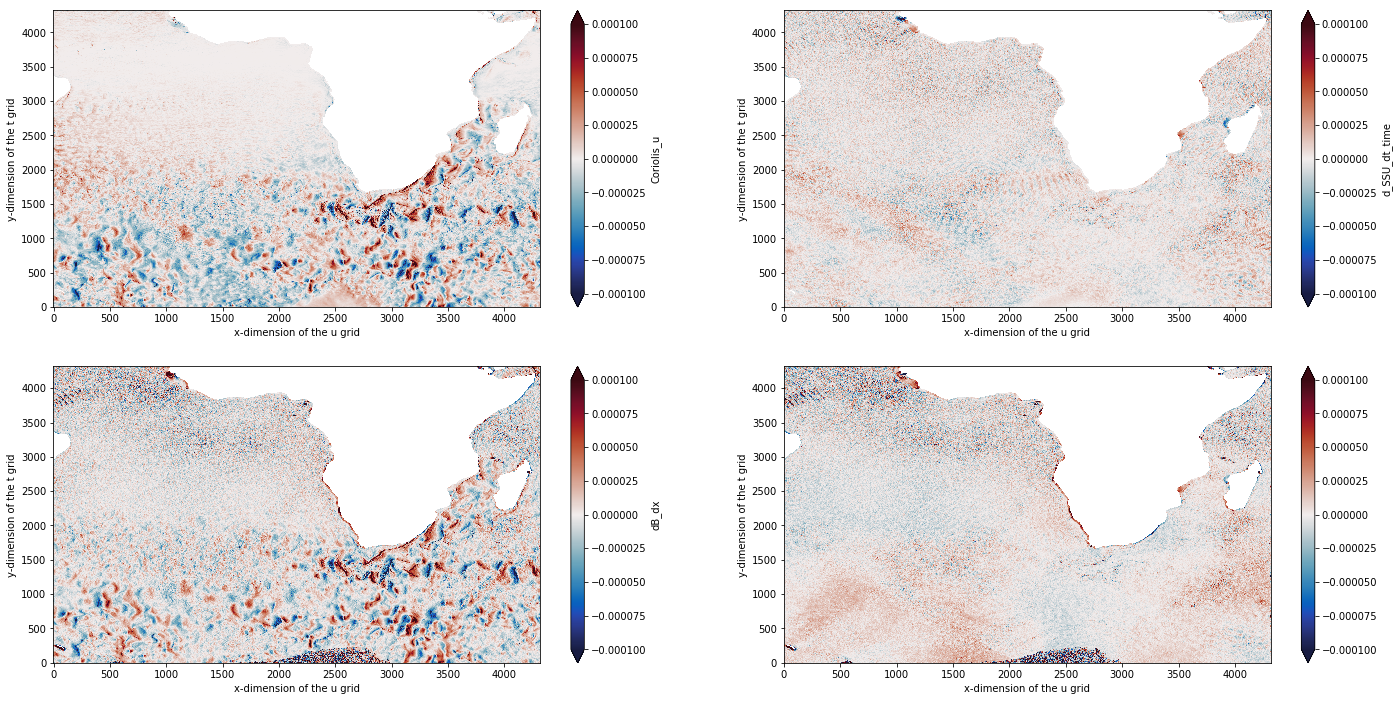

In [21]:
fig = plt.figure(figsize = (24,12))

plt.subplot(221)
ds['Coriolis_u'].isel(time=310).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(222)
ds['d_SSU_dt_time'].isel(time=310).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(223)
ds['dB_dx'].isel(time=310).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(224)
residuals_u_face1.isel(time=310).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)


In [22]:
# std
residuals_u_face1_std = residuals_u_face1.isel(i_g=slice(500,1500),j=slice(500,2000)).std(['i_g','j']).load()
Coriolis_u_std = ds['Coriolis_u'].isel(i_g=slice(500,1500),j=slice(500,2000)).std(['i_g','j']).load()
dB_dx_std = ds['dB_dx'].isel(i_g=slice(500,1500),j=slice(500,2000)).std(['i_g','j']).load()
d_SSU_dt_time_std = ds['d_SSU_dt_time'].isel(i_g=slice(500,1500),j=slice(500,2000)).std(['i_g','j']).load()

In [28]:
# mean
residuals_u_face1_mean = residuals_u_face1.isel(i_g=slice(500,1500),j=slice(500,2000)).mean(['i_g','j']).load()
Coriolis_u_mean = ds['Coriolis_u'].isel(i_g=slice(500,1500),j=slice(500,2000)).mean(['i_g','j']).load()
dB_dx_mean = ds['dB_dx'].isel(i_g=slice(500,1500),j=slice(500,2000)).mean(['i_g','j']).load()
d_SSU_dt_time_mean = ds['d_SSU_dt_time'].isel(i_g=slice(500,1500),j=slice(500,2000)).mean(['i_g','j']).load()

In [32]:
# rms^2
residuals_u_face1_rms = (residuals_u_face1.isel(i_g=slice(500,1500),j=slice(500,2000))**2).mean(['i_g','j']).load()
Coriolis_u_rms = (ds['Coriolis_u'].isel(i_g=slice(500,1500),j=slice(500,2000))**2).mean(['i_g','j']).load()
dB_dx_rms = (ds['dB_dx'].isel(i_g=slice(500,1500),j=slice(500,2000))**2).mean(['i_g','j']).load()
d_SSU_dt_time_rms = (ds['d_SSU_dt_time'].isel(i_g=slice(500,1500),j=slice(500,2000))**2).mean(['i_g','j']).load()

(0, 2.5e-05)

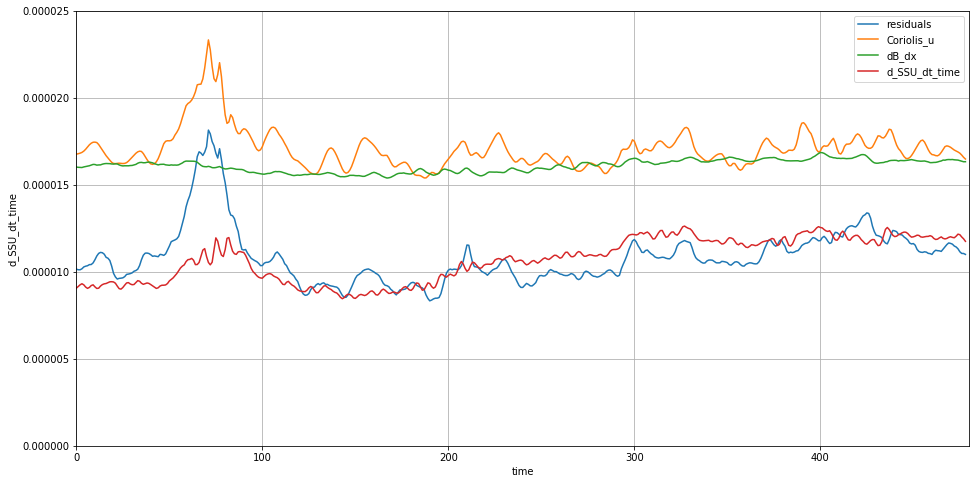

In [27]:
# std
fig, ax = plt.subplots(figsize=(16,8))
labels = ['residuals', 'Coriolis_u','dB_dx','d_SSU_dt_time']

residuals_u_face1_std.plot(ax=ax, label=labels[0])
Coriolis_u_std.plot(ax=ax, label=labels[1])
dB_dx_std.plot(ax=ax, label=labels[2])
d_SSU_dt_time_std.plot(ax=ax, label=labels[3])
ax.legend(); ax.grid()
ax.set_xlim([0,480])
ax.set_ylim([0,2.5*1e-5])

(0, 8e-05)

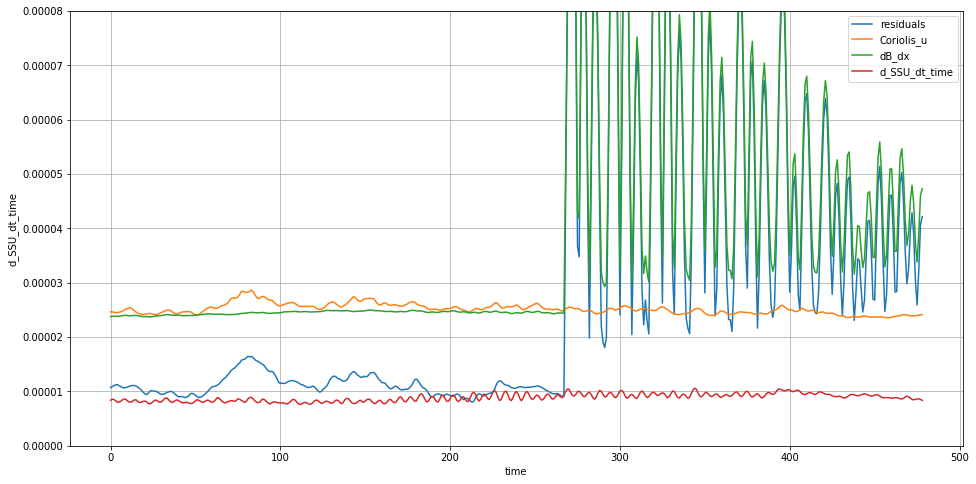

In [20]:
fig, ax = plt.subplots(figsize=(16,8))
labels = ['residuals', 'Coriolis_u','dB_dx','d_SSU_dt_time']

residuals_u_face1_std.plot(ax=ax, label=labels[0])
Coriolis_u_std.plot(ax=ax, label=labels[1])
dB_dx_std.plot(ax=ax, label=labels[2])
d_SSU_dt_time_std.plot(ax=ax, label=labels[3])
ax.legend(); ax.grid()
#ax.set_xlim([8*1e-8,2*1e-4])
ax.set_ylim([0,8*1e-5])

(0, 6e-10)

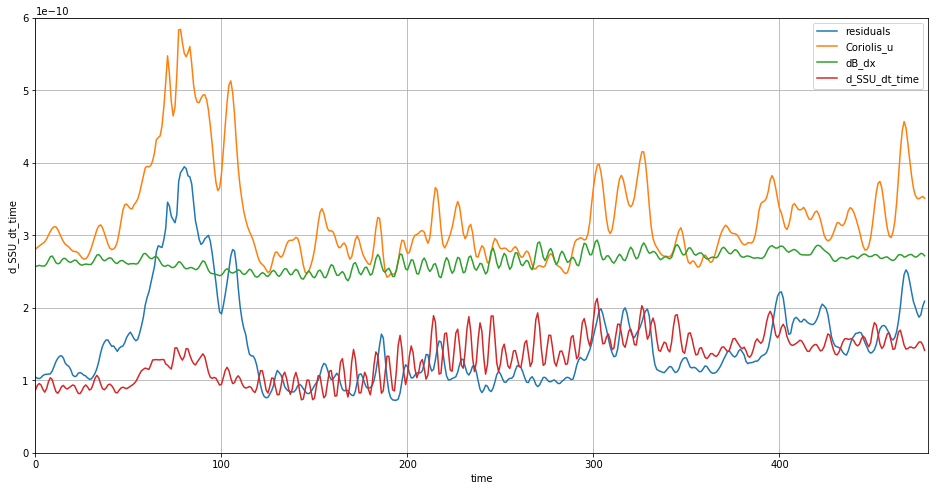

In [34]:
# rms^2
fig, ax = plt.subplots(figsize=(16,8))
labels = ['residuals', 'Coriolis_u','dB_dx','d_SSU_dt_time']

residuals_u_face1_rms.plot(ax=ax, label=labels[0])
Coriolis_u_rms.plot(ax=ax, label=labels[1])
dB_dx_rms.plot(ax=ax, label=labels[2])
d_SSU_dt_time_rms.plot(ax=ax, label=labels[3])
ax.legend(); ax.grid()
ax.set_xlim([0,480])
ax.set_ylim([0,6*1e-10])

(-2e-05, 2e-05)

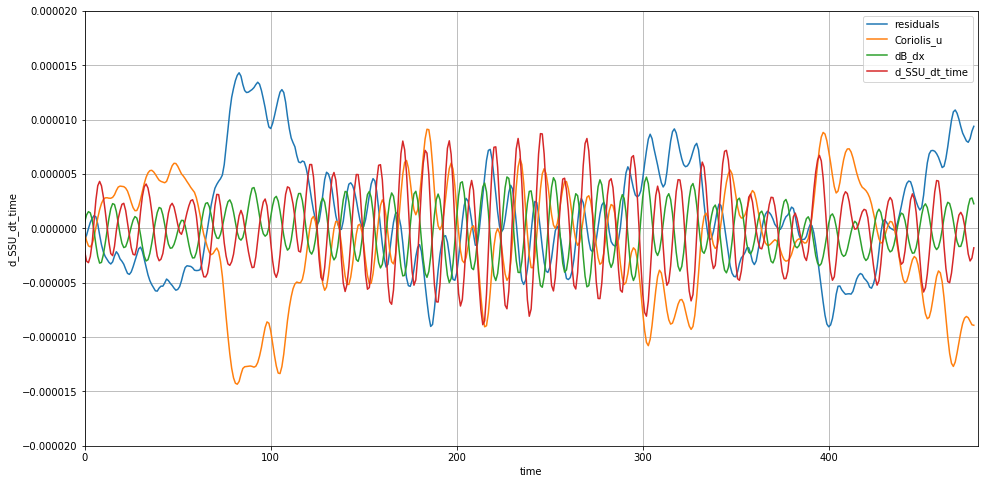

In [31]:
# mean
fig, ax = plt.subplots(figsize=(16,8))
labels = ['residuals', 'Coriolis_u','dB_dx','d_SSU_dt_time']

residuals_u_face1_mean.plot(ax=ax, label=labels[0])
Coriolis_u_mean.plot(ax=ax, label=labels[1])
dB_dx_mean.plot(ax=ax, label=labels[2])
d_SSU_dt_time_mean.plot(ax=ax, label=labels[3])
ax.legend(); ax.grid()
ax.set_xlim([0,480])
ax.set_ylim([-2*1e-5,2*1e-5])

In [84]:
cluster.scheduler.close()

<Future finished result=None>